# Using the Data Reader classes to import some Marine spectral data

## The LiftDyn reader class

In this first example we demonstrate how to import a lift dyn file and create some plots.

Start with defining some import statements and reading the data

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import os
import logging
from scipy.constants import nautical_mile

from hmc_utils.misc import (create_logger)

# make sure that the local version of the hmc_marine modules are found first
import hmc_marine.data_readers as dr

data_location = "data"
if not os.path.isdir(data_location):
    # in case we are running in the explorer we need to go one level up for reading the data
    data_location = "../data"
file_name = os.path.join(data_location, "hermod_11_deep_POI1-acc-RAO.stf_plt")

logger = create_logger(console_log_level=logging.INFO)
logger.debug("module loaded : {}".format(dr.__file__))
logger.info("Reading Liftdyn file {}".format(file_name))

lift = dr.LiftDynReader(file_name=file_name)
lift.make_report(short_summary=True)  # create some information about the RAO's we have loaded

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


  INFO : Reading Liftdyn file ../data\hermod_11_deep_POI1-acc-RAO.stf_plt
# of RAO's           : 6
RAO_Acceleration_incl_horz_gravity_component_AX-g*sin   : array shape (250, 8)  ; (r, phi)[0] = (  3.63e-03,  -3.11e+00)
RAO_Acceleration_incl_horz_gravity_component_AY+g*sin   : array shape (250, 8)  ; (r, phi)[0] = (  3.46e-06,  -1.52e+00)
RAO_Acceleration_incl_horz_gravity_component_AZ         : array shape (250, 8)  ; (r, phi)[0] = (  1.00e-04,   3.14e+00)
RAO_Acceleration_incl_horz_gravity_component_ARX        : array shape (250, 8)  ; (r, phi)[0] = (  2.02e-09,   1.62e+00)
RAO_Acceleration_incl_horz_gravity_component_ARY        : array shape (250, 8)  ; (r, phi)[0] = (  2.12e-06,  -3.11e+00)
RAO_Acceleration_incl_horz_gravity_component_ARZ        : array shape (250, 8)  ; (r, phi)[0] = (  3.56e-09,  -2.22e+00)


Now the object `lift` contains all the information about the import RAO's. We can make a plot of the 6 DOF using the plot method

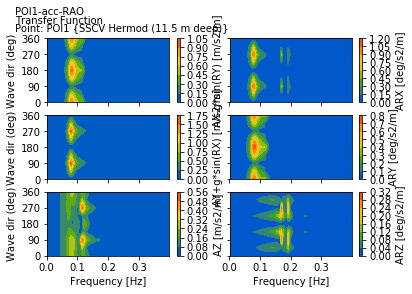

In [2]:
fig, axis = lift.plot()
plt.show()

We can also change the axis from Frequency to Period

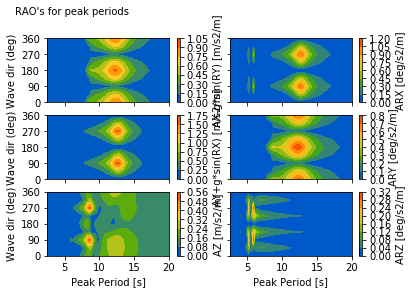

In [3]:
fig, axis = lift.plot(x_axis_type="period", plot_title="RAO's for peak periods", x_axis_lim=(2.5, 20))
plt.show()

Or we could only plot one RAO, for instance the Surge RAO

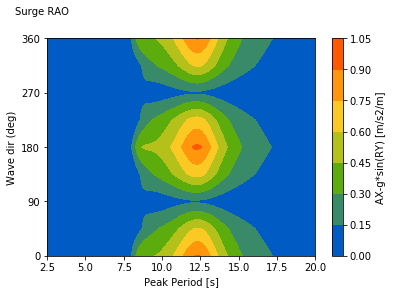

In [4]:
fig, axis = lift.plot(x_axis_type="period", plot_title="Surge RAO", x_axis_lim=(2.5, 20), plot_index_selection=[0])
plt.show()

To access the data we can do

In [5]:
rao_surge = lift.dof_components[0]
rao_surge.report()

TITLES   POI1-acc-RAO
TITLES   Transfer Function
TITLES   Point: POI1 {SSCV Hermod (11.5 m deep)}
TITLES   
PROJECT  P:\I0450\I0450-Engineering\JT300\70JT300-RP02 - Jacket Sections Design Accelerations during Transport suspended from the HLV Thialf Cranes\TopondeckHermod\Nov-16\Liftdyn-WithJCK\hermod_11_deep.inp 08-Nov-2016 16:47:32
SUBJECT  Murchison jacket top section on Hermod deck 11.5m draft
DATE     29-Nov-2016
JOBNUM   I/0450-JT300
DRANUM   Figure 1
TEXVER   R.A.O. Acceleration incl. horz. gravity component AX-g*sin(RY) (m/s2/m) in global axes
TEXHOR   Wave frequency (rad/s)


rao_surge now is the LiftDynComponent object of one RAO component. The 2D data array is attached to the .data field


In [6]:
logger.info("Read Surgae RAO with following data : shape = {} type = {} item type {} first value {}"
            "".format(rao_surge.data.shape, type(rao_surge.data), type(rao_surge.data[0, 0]), rao_surge.data[0, 0]))

  INFO : Read Surgae RAO with following data : shape = (250, 8) type = <class 'numpy.ndarray'> item type <class 'numpy.complex128'> first value (-0.0036312212217646895-0.00010061372352477288j)


The data can be resampled using the resample routine. Note that you have to pass the new directions and frequencies in *radians* and *rad/s*

In [7]:
lift.resample_data(new_directions=np.linspace(0, 2 * pi, endpoint=False, num=32),
                   new_frequencies=np.linspace(lift.frequencies[0], lift.frequencies[-1], endpoint=True, num=500))

All data now has been replace with a 32 x 500 data fie

In [8]:
rao_surge = lift.dof_components[0]
logger.info("Read Surgae RAO with following data : shape = {} type = {} item type {} first value {}"
            "".format(rao_surge.data.shape, type(rao_surge.data), type(rao_surge.data[0, 0]), rao_surge.data[0, 0]))

  INFO : Read Surgae RAO with following data : shape = (500, 32) type = <class 'numpy.ndarray'> item type <class 'numpy.complex128'> first value (-0.0036312212217646895-0.00010061372352477288j)


We can plot it again to see that the data is the same (only at a higher resolution)

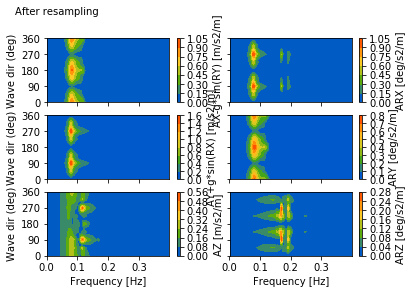

In [9]:
fig4, axis4 = lift.plot(plot_title="After resampling")
plt.show()

## Applying a velocity shift

When dealing with a moving vessel we would like to apply a velocity shift in order to take into account the encountered frequency. In the LiftDynReader class this can be done on a range of velocity. Each RAO is stored in a list. When processing the data we can quickly pick the RAO for the current velocity. This save time, as we only have to do the interpolation involved with the shift of the RAO one time. 

As a first step, calculate the shifted RAO's over a range of 0 to 5 m/s (Note that velocities are always expressed in terms of m/s)

In [10]:
lift.calculate_rao_per_velocity(n_velocity=20, max_velocity=5)

In the next step, lets assumed tha we are sailing at 5 knots, which is

In [11]:
speed_in_kn = 5.0
speed_in_ms = speed_in_kn * nautical_mile / 3600.0
print("Sailing at {:.1f} kn which is {:.1f} m/s".format(speed_in_kn, speed_in_ms))

Sailing at 5.0 kn which is 2.6 m/s


Now we can pick the RAO belonging to the current speed in meter per seconds

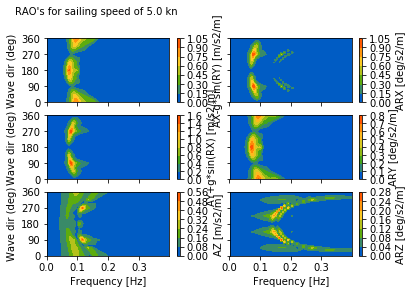

In [12]:
lift.pick_rao_for_speed(sailing_speed=speed_in_ms)
fig, axis = lift.plot(plot_title="RAO's for sailing speed of {} kn".format(speed_in_kn))
plt.show()